## Import Libraries

- `numpy` for data processing
- `onnxruntime` for model inference
- `cv2` and `PIL` for image reading and visualizing

In [1]:
import cv2
import numpy as np
import onnxruntime
from PIL import Image

## Prepare model and image demo

In [2]:
onnx_path = 'yolox.onnx' # the model weight with onnx format
img_path = 'demo/1.jpg' # the image path

## Wrapping reasoning into an interface

In [3]:
class Inference(object):

    classes = ('Pedestrian', 'Cyclist', 'Car', 'Truck', 'Tram', 'Tricycle')
    colors = (((220, 20, 60), (106, 0, 228), (0, 60, 100),
               (119, 11, 32), (0, 0, 142), (0, 0, 230), ))


    def __init__(self, weight, score_threshold=0.3, iou_threshold=0.65) -> None:
        self.session = onnxruntime.InferenceSession(weight)
        self.score_threshold = score_threshold
        self.iou_threshold = iou_threshold


    def pre_process(self, img):
        img = cv2.resize(img, (480, 480)).astype(np.float32)
        img = img.transpose((2, 0, 1))
        img = np.expand_dims(img, 0)
        return img


    def post_process(self, result_list):

        def iou(box1, box2):
            area1 = (box1[3] - box1[1]) * (box1[2] - box1[0])
            area2 = (box2[3] - box2[1]) * (box2[2] - box2[0])
            inter_area = (min(box1[2], box2[2]) - max(box1[0], box2[0])) * \
                        (min(box1[3], box2[3]) - max(box1[1], box2[1]))
            return inter_area / (area1 + area2 - inter_area)

        def nms(boxes, iou_threshold=0.65):
            keep = []
            count = len(boxes)
            banned = [False] * count
            for i in range(count):
                if banned[i]:
                    continue
                keep.append(i)
                for j in range(i+1, count):
                    if banned[j]:
                        continue
                    if iou(boxes[i], boxes[j]) > iou_threshold:
                        banned[j] =  True
            return keep

        bbox_list = []
        score_list = []
        label_list = []
        for i in range(result_list.shape[0]):
            if result_list[i][4] >= self.score_threshold:
                bbox = result_list[i][:4]
                bbox_list.append((bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()))
                score_list.append(result_list[i][4].item())
                label_list.append(int(result_list[i][5].item()))
        keep = nms(bbox_list)
        bbox_list = [bbox_list[i] for i in keep]
        score_list = [score_list[i] for i in keep]
        label_list = [label_list[i] for i in keep]

        return bbox_list, score_list, label_list


    def detect(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (1920, 1080))
        inputs = self.pre_process(img)

        inputs = {self.session.get_inputs()[0].name: inputs}
        outs = self.session.run(None, inputs)
        result_list = outs[0]

        bbox_list, score_list, label_list = self.post_process(result_list)
        count = len(label_list)
        for i in range(count):
            x1, y1, x2, y2 = bbox_list[i]
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), self.colors[label_list[i]], 2)
            text = '{}:{:.1f}'.format(self.classes[label_list[i]], score_list[i]*100)
            fontFace = cv2.FONT_HERSHEY_COMPLEX
            fontScale = 0.8
            fontcolor = (255, 255, 255)
            thickness = 1 
            lineType = 4
            retval, baseLine = cv2.getTextSize(text, fontFace=fontFace, fontScale=fontScale, thickness=thickness)
            topleft = (int(x1), int(y1)+20 - retval[1]+3)
            bottomright = (topleft[0] + retval[0], topleft[1] + retval[1]+5)
            cv2.rectangle(img, (topleft[0], topleft[1] - baseLine), bottomright,thickness=-1, color=(0,0,0))
            cv2.putText(img, text,(int(x1), int(y1)+20), fontFace, fontScale, fontcolor, thickness, lineType)


        return Inference.show_img(img)

    @staticmethod
    def show_img(img):
        if isinstance(img, str):
            img = cv2.imread(img)
            img = cv2.resize(img, (1920, 1080))
        return Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        

## Visualizing the result

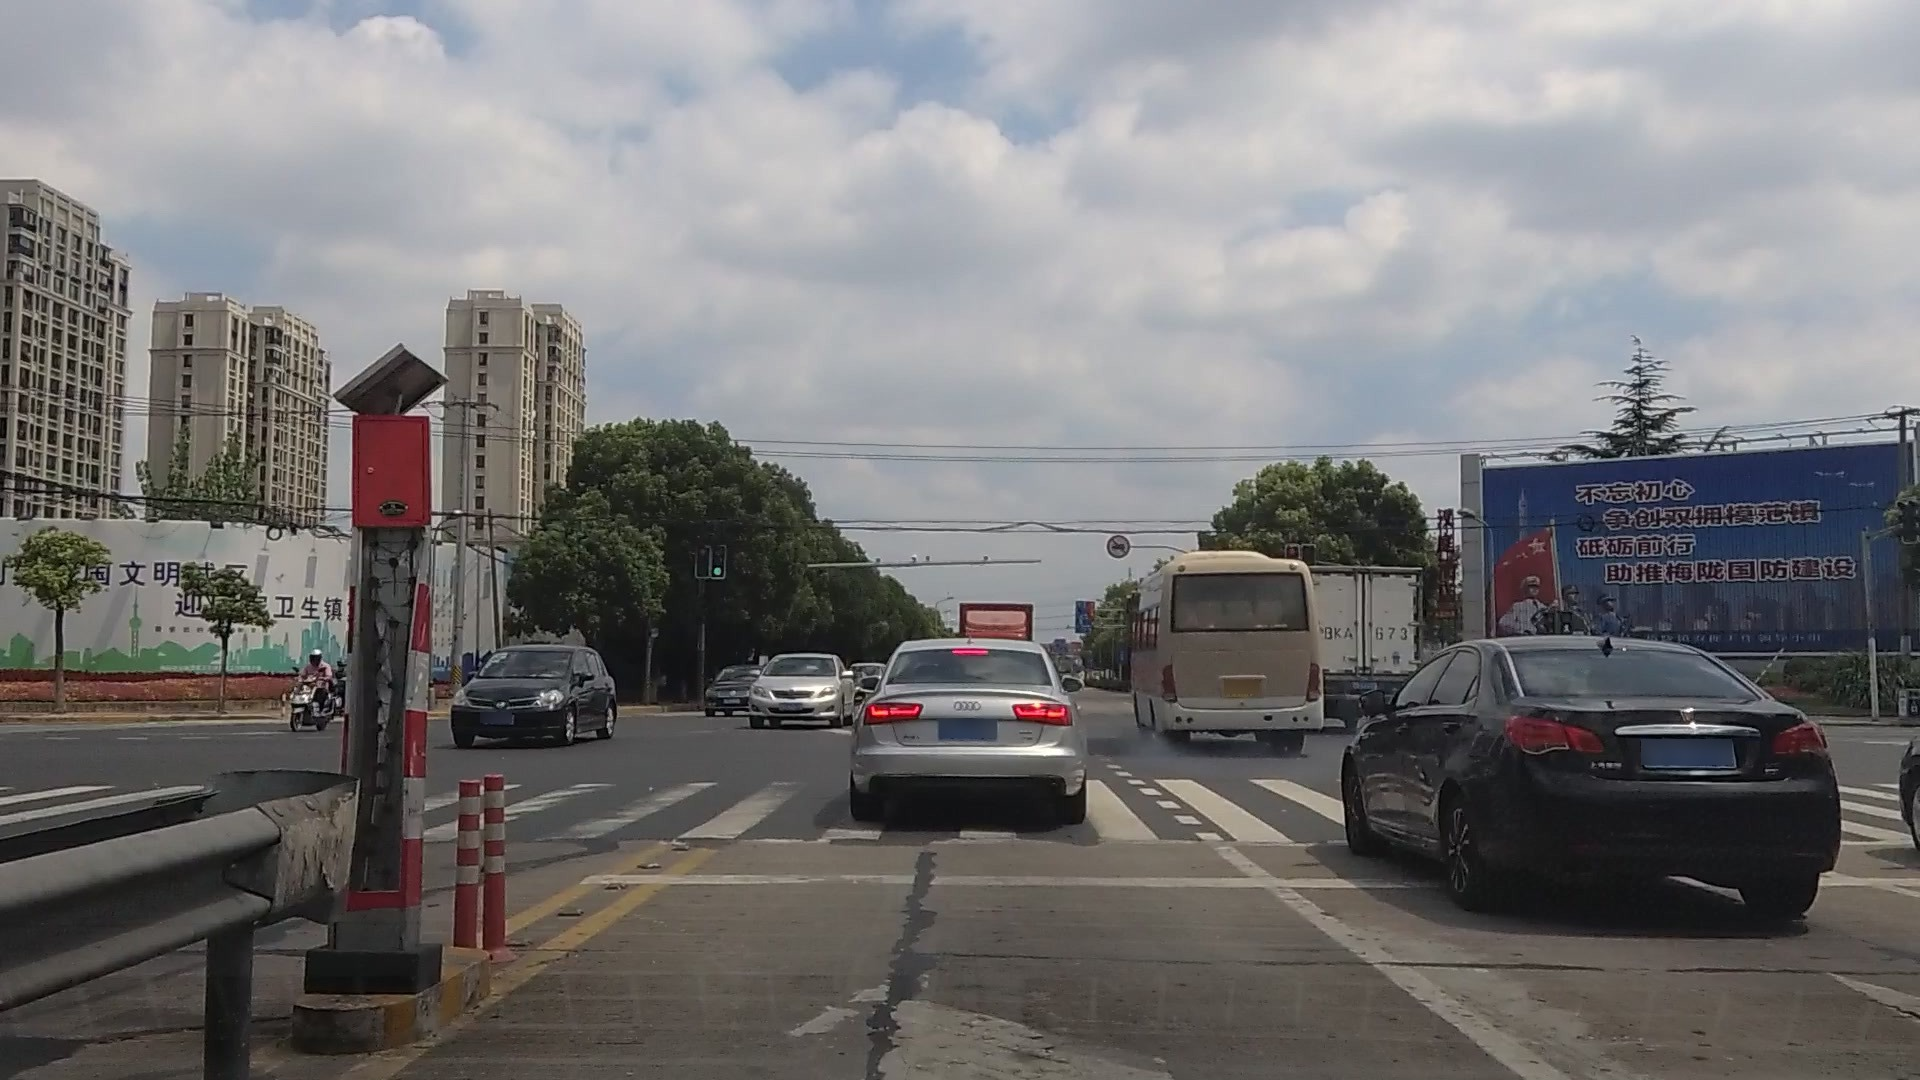

In [4]:
inference = Inference(onnx_path)
inference.show_img(img_path)


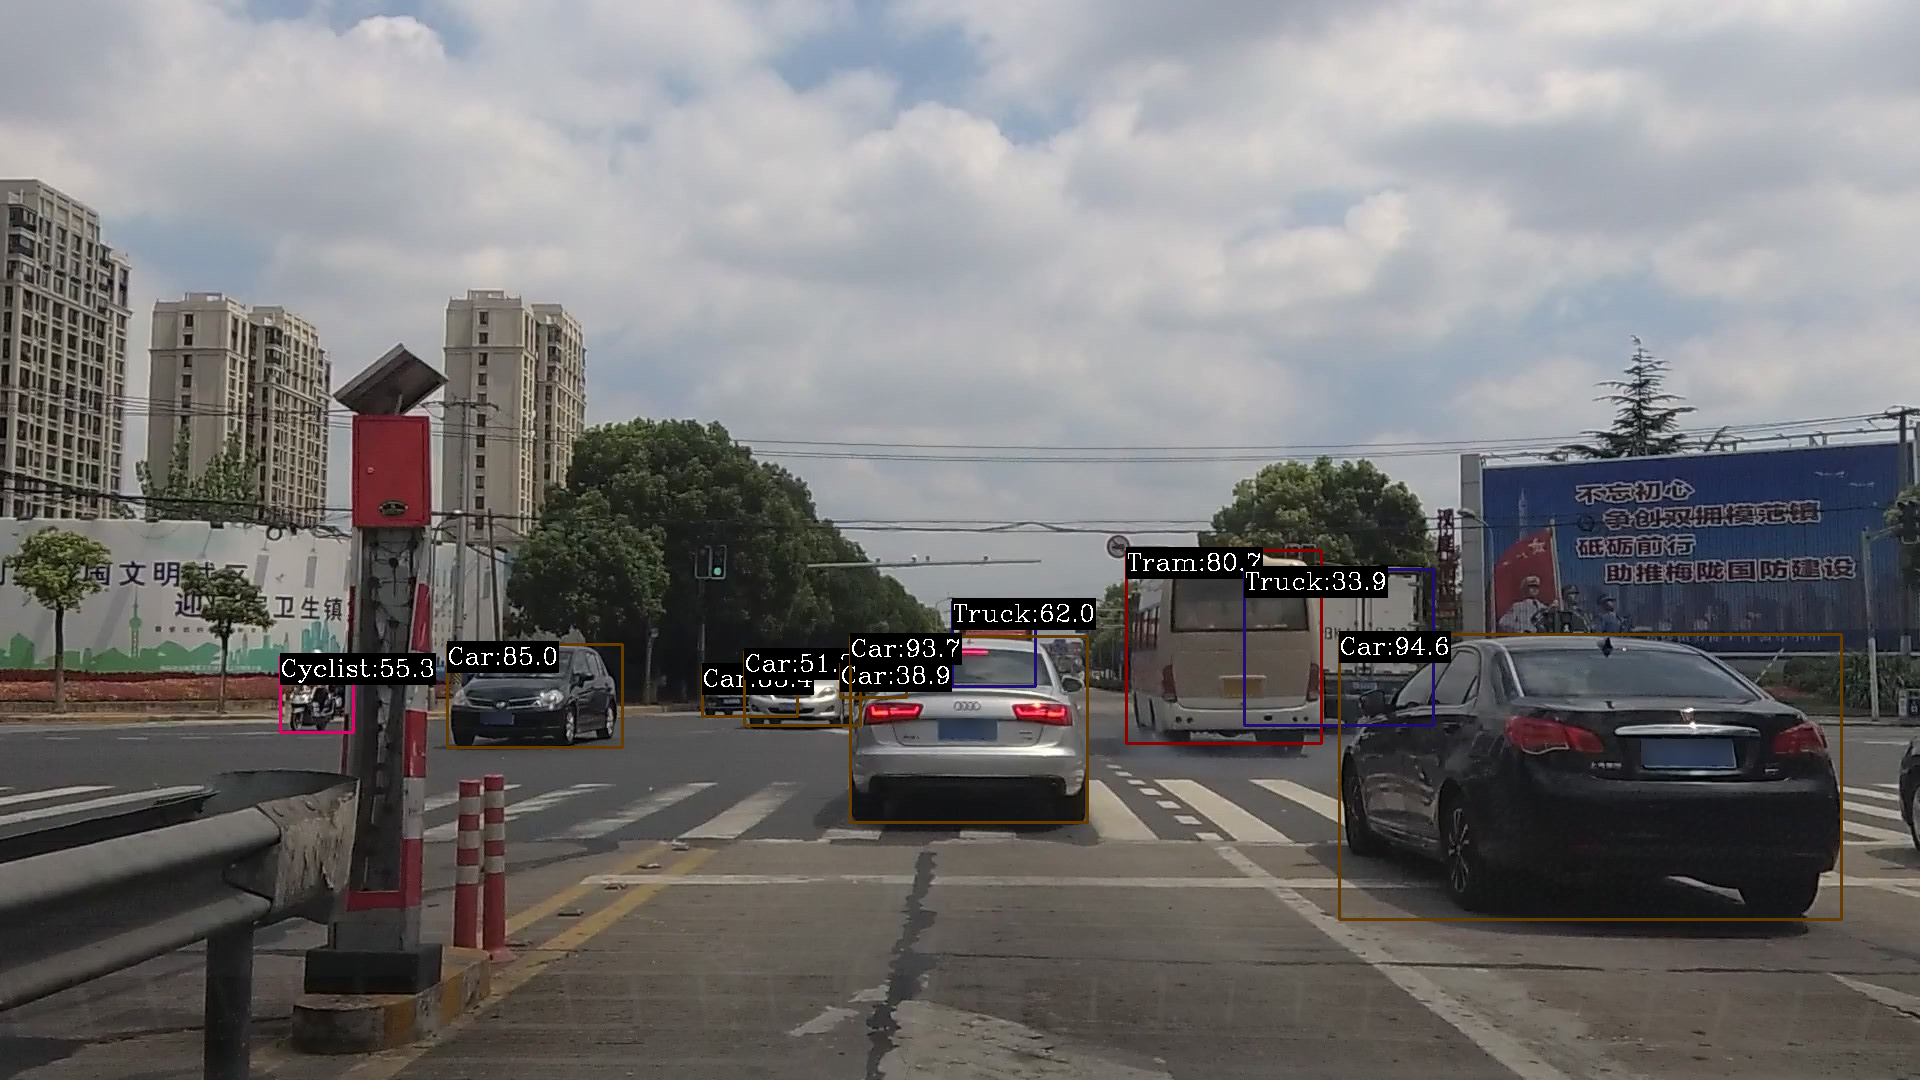

In [5]:
inference.detect(img_path)